In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.patches import Patch
import torch
import dgl
import random
import io


from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D,IPythonConsole
from PIL import Image

from omtra.load.quick import datamodule_from_config
import omtra.load.quick as quick_load

from omtra.constants import charge_map, lig_atom_type_map

from omtra.models.ligand_encoder.vq import LigandVQVAE

from omtra.tasks.register import task_name_to_class
from omtra.eval.system import SampledSystem


/net/galaxy/home/koes/ltoft/.conda/envs/omtra/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def move_feats_to_t1(task_name: str, g: dgl.DGLHeteroGraph, t: str = '0'):
    task = task_name_to_class(task_name)
    for m in task.modalities_present:

        num_entries = g.num_nodes(m.entity_name) if m.is_node else g.num_edges(m.entity_name)
        if num_entries == 0:
            continue

        data_src = g.nodes if m.is_node else g.edges
        dk = m.data_key
        en = m.entity_name

        if t == '0' and m in task.modalities_fixed:
            data_to_copy = data_src[en].data[f'{dk}_1_true']
        else:
            data_to_copy = data_src[en].data[f'{dk}_{t}']

        data_src[en].data[f'{dk}_1'] = data_to_copy

    return g

def dgl_to_rdkit(g):
    """ Converts one DGL molecule to RDKit ligand """
    g = move_feats_to_t1('denovo_ligand', g, '1_true')
    rdkit_ligand = SampledSystem(g).get_rdkit_ligand()
    return rdkit_ligand

In [3]:
def display_ligands(pharmit_dataset, indices, n_cols=3, img_size=(800,800)):

    mol_images = []
    n_mols = len(indices)

    for i in indices:
        g = pharmit_dataset[('denovo_ligand', i)]
        ligand = dgl_to_rdkit(g)

        # Compute 2D coordinates
        AllChem.Compute2DCoords(ligand)

        # Draw the molecule
        drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
        options = drawer.drawOptions()
        options.useBWAtomPalette()
        

        for idx, a in enumerate(g.nodes['lig'].data['a_1_true'].cpu().numpy().flatten().tolist()):
            options.atomLabels[idx] = f"{lig_atom_type_map[a]}, {idx}"


        drawer.DrawMolecule(ligand)
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        mol_images.append(img)

    # Assemble grid of images
    n_rows = (n_mols + n_cols - 1) // n_cols
    grid_width = img_size[0] * n_cols
    grid_height = img_size[1] * n_rows
    grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

    for idx, img in enumerate(mol_images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * img_size[0], row * img_size[1]))

    # Display
    dpi = 100
    figsize = (grid_width / dpi, grid_height / dpi)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


## Embedding Vector Visualization

In [4]:
# Get pharmit datases
cfg = quick_load.load_cfg(overrides=['task_group=no_protein'], pharmit_path='/net/galaxy/home/koes/icd3/moldiff/OMTRA/data/pharmit') # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("train")
pharmit_train_dataset = train_dataset.datasets['pharmit']

val_dataset = datamodule.load_dataset("val")
pharmit_val_dataset = val_dataset.datasets['pharmit']

⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


In [5]:
def get_codebook_indices(model, g):
    z_e, mask = model.encoder(g)  # Encoder output
    mask = mask.cpu().numpy().flatten().tolist()
    _, z_d, codebook_indices, _, _ = model.vq_vae(z_e)
    codebook_indices = codebook_indices.cpu().numpy().flatten().tolist()
    return codebook_indices, z_d, mask


def display_ligand_embeddings(model, pharmit_dataset, index_to_color, n_mols=1, indices=None, n_cols=3, img_size=(600,600)):
    
    if indices is None:
        indices = [random.randint(0, len(pharmit_dataset)-1) for _ in range(n_mols)]
        print(f"Using random indices: {indices}")
    else:
        n_mols = len(indices)
    
    model.eval()

    mol_images = []

    # Collect the codebook indices actually used in these molecules
    used_codebook_indices = set()

    mask_indicator = {False:'', True:'**'}

    for i in indices:
        g = pharmit_dataset[('denovo_ligand', i)]
        ligand = dgl_to_rdkit(g)
        codebook_indices, _, mask = get_codebook_indices(model, g)
        used_codebook_indices.update(codebook_indices)

        # Compute 2D coordinates
        AllChem.Compute2DCoords(ligand)

        # Create atom color map
        atom_colors = {idx: [index_to_color[val]] for idx, val in enumerate(codebook_indices)}
        highlight_radii = {idx: 0.3 for idx in atom_colors}

        # Draw the molecule
        drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
        options = drawer.drawOptions()
        options.useBWAtomPalette()
        
        for idx, (a, c) in enumerate(zip(
            g.nodes['lig'].data['a_1_true'].cpu().numpy().flatten().tolist(),
            g.nodes['lig'].data['c_1_true'].cpu().numpy().flatten().tolist())):
            if charge_map[c] == 0:
                options.atomLabels[idx] = f"{lig_atom_type_map[a]}{mask_indicator[mask[idx]]}"
            else:
                options.atomLabels[idx] = f"{lig_atom_type_map[a]} {charge_map[c]}{mask_indicator[mask[idx]]}"

        drawer.DrawMoleculeWithHighlights(
            ligand, '', atom_colors, {}, highlight_radii, {}
        )
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        mol_images.append(img)

    # Assemble grid of images
    n_rows = (n_mols + n_cols - 1) // n_cols
    grid_width = img_size[0] * n_cols
    grid_height = img_size[1] * n_rows
    grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

    for idx, img in enumerate(mol_images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * img_size[0], row * img_size[1]))

    # Create legend patches for used codebook indices
    legend_patches = [
        Patch(color=index_to_color[idx], label=f'Codebook {idx}')
        for idx in sorted(used_codebook_indices)
    ]
    print("number of codebook vectors used:", len(used_codebook_indices))
    # Display
    dpi = 100
    figsize = (grid_width / dpi, grid_height / dpi)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')
    plt.tight_layout()
    plt.show()


In [6]:
import matplotlib.pyplot as plt
import colorsys

def lighten_color(color, amount=1.3):
    """
    Lightens the given RGBA color by multiplying the lightness (L in HLS) by amount.
    """
    r, g, b, a = color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = min(1, l * amount)  # increase lightness but max 1
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return (r, g, b, a)

### Baseline

––––––– Val ––––––––
number of codebook vectors used: 11


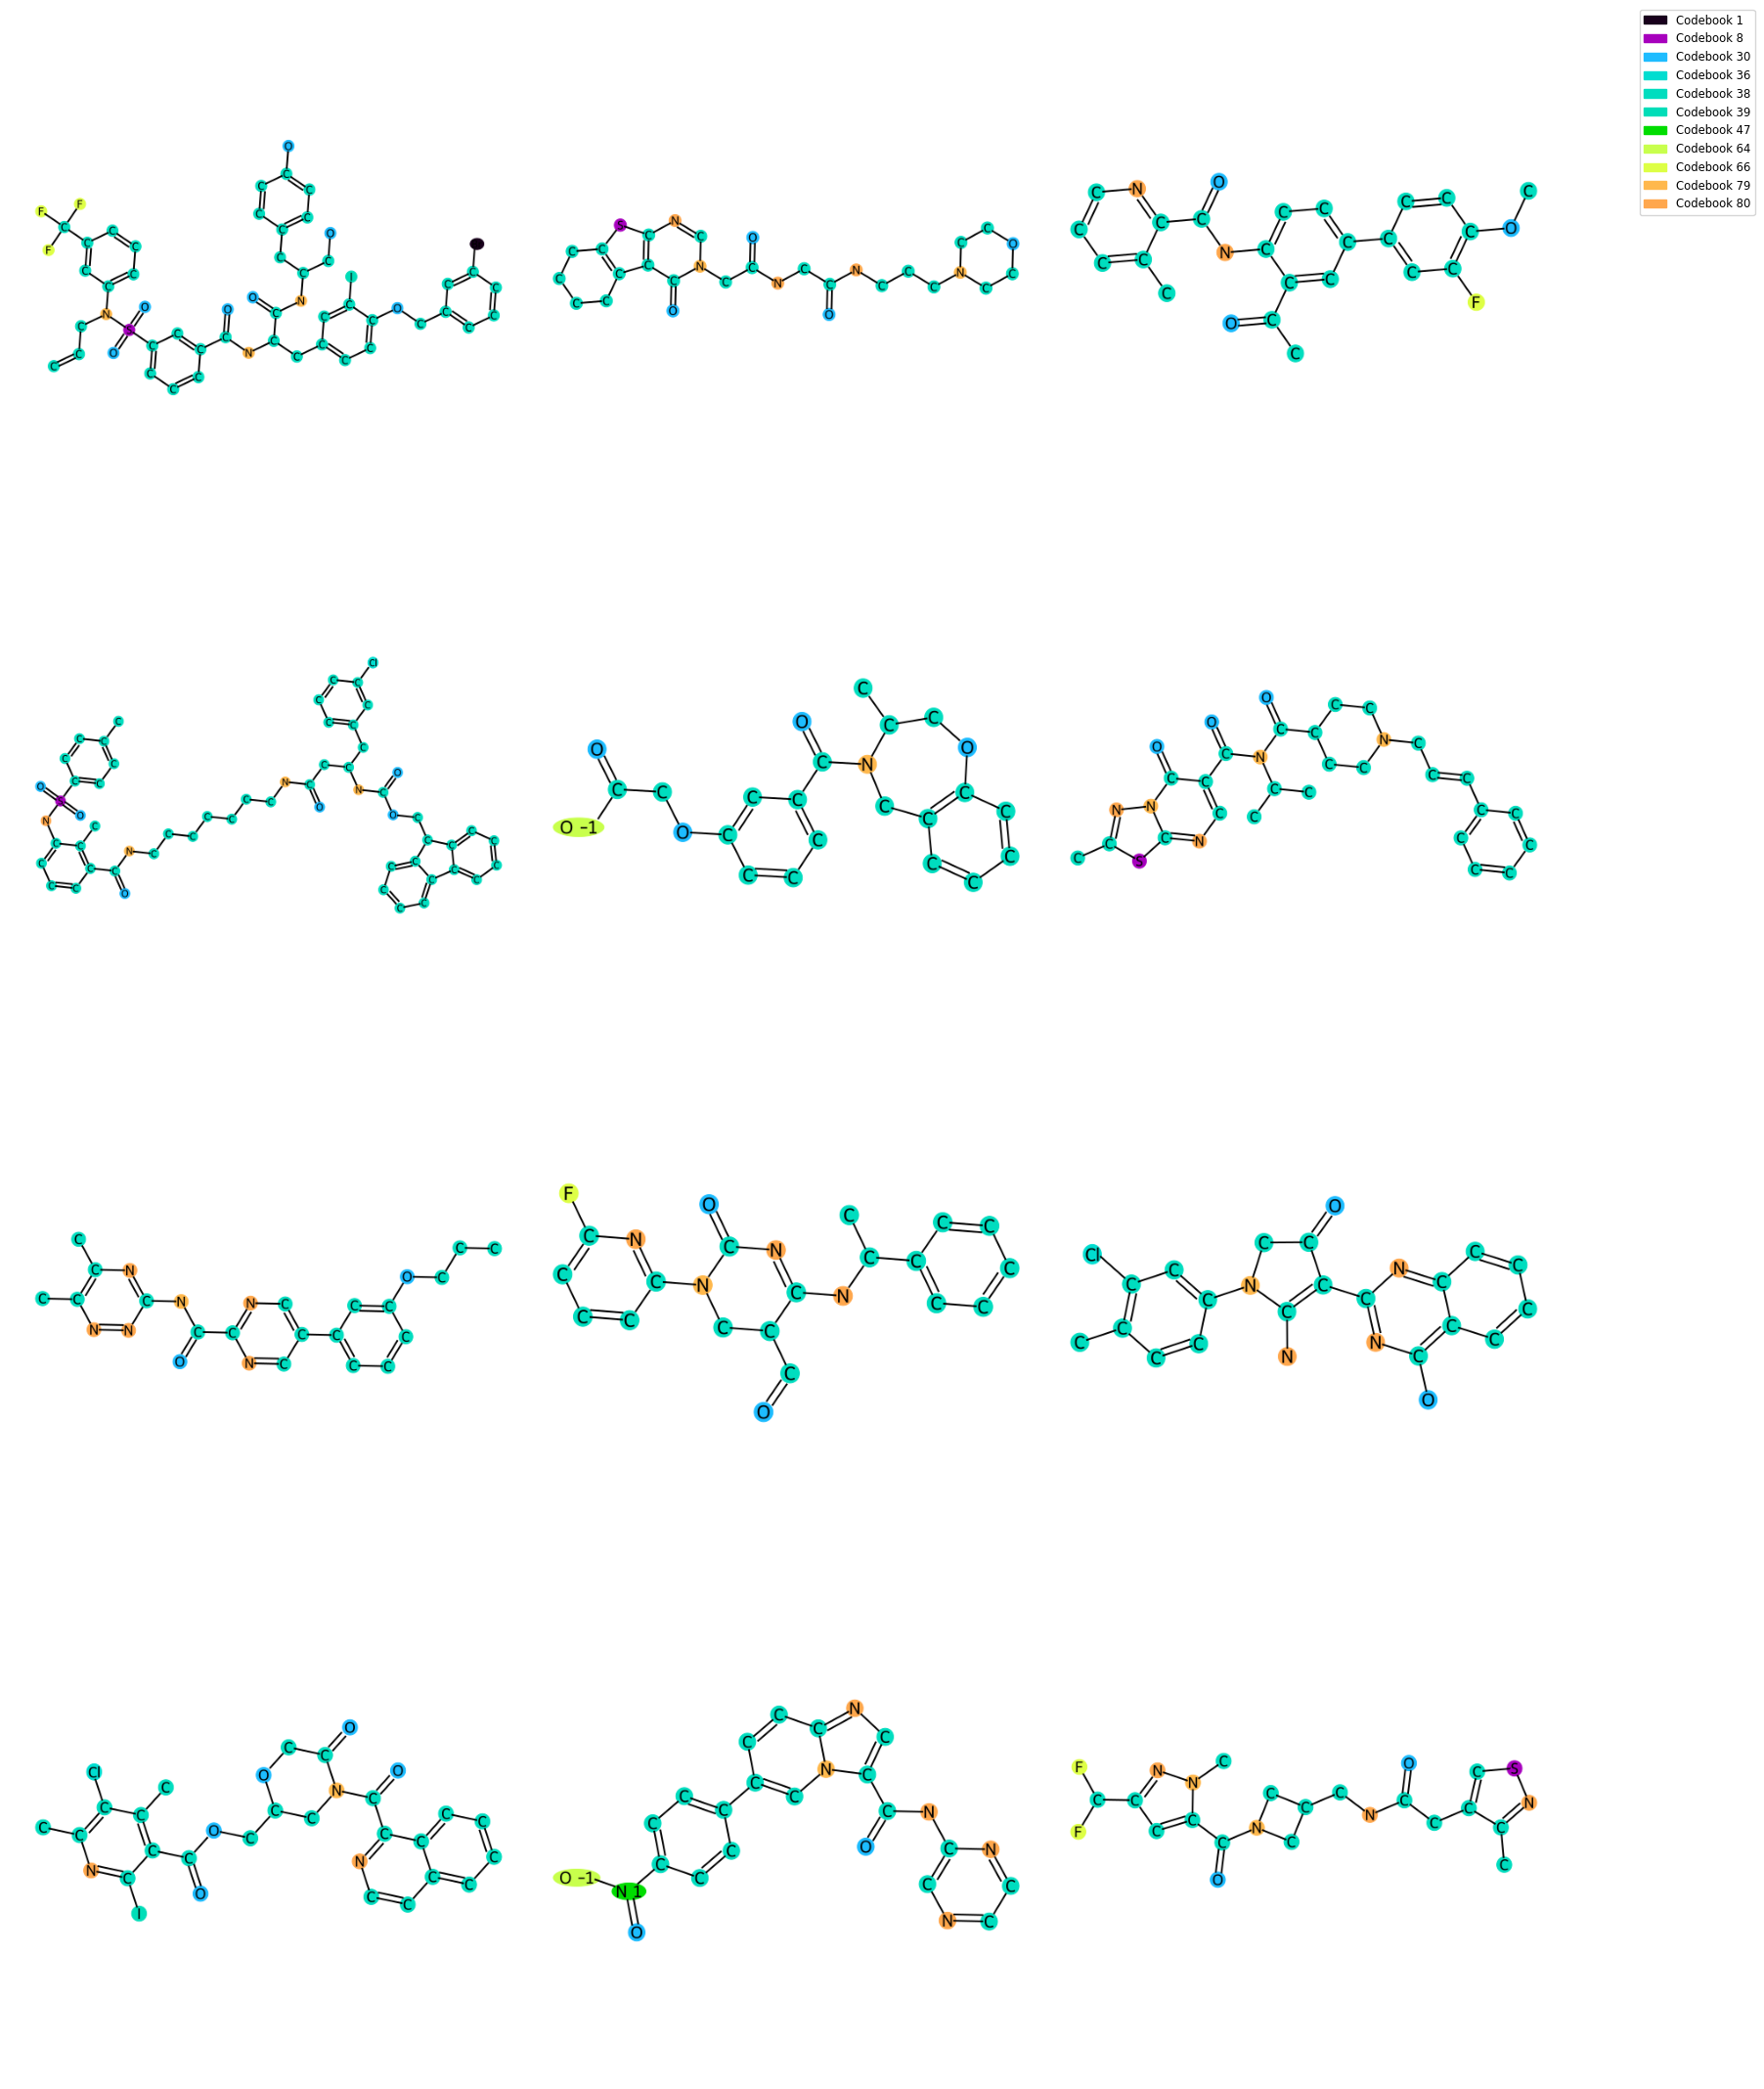

In [7]:
# BASELINE:
checkpoint = "/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-06-25/EMA_baseline_2025-06-25_16-36-349997/checkpoints/last.ckpt"

model = LigandVQVAE.load_from_checkpoint(checkpoint)

num_embeddings = model.vq_vae.num_embeddings
colormap = matplotlib.colormaps.get_cmap('nipy_spectral')

# Generate lightened colormap
index_to_color = {
    i: lighten_color(colormap(i / (num_embeddings - 1))[:4], amount=1.3)
    for i in range(num_embeddings)
}

print("––––––– Val ––––––––")
display_ligand_embeddings(model, pharmit_val_dataset, index_to_color, indices=[3897329, 3052029, 606915, 1830471, 972777, 1316962, 3689126, 5496548, 5148961, 3725602, 1171866, 2014161])

In [8]:
# Use extra features
checkpoint = "/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-06-25/EMA_extra_feats_2025-06-25_16-33-115380/checkpoints/last.ckpt"
model = LigandVQVAE.load_from_checkpoint(checkpoint)


print("––––––– Val ––––––––")
display_ligand_embeddings(model, pharmit_val_dataset, index_to_color, indices=[3897329, 3052029, 606915, 1830471, 972777, 1316962, 3689126, 5496548, 5148961, 3725602, 1171866, 2014161])

––––––– Val ––––––––


KeyError: 'impl_H_1_true'

In [11]:
def predicted(model, g):
    z_e, mask = model.encoder(g)  # Encoder output
    mask = mask.cpu().numpy().flatten().tolist()
    _, z_d, _, _, _ = model.vq_vae(z_e)
    logits = model.decoder(g, z_d)

    pred = {}
    for feat, logit in logits.items():
        pred[feat] = torch.argmax(logit, dim=1)

    return pred

def display_performance(model, pharmit_dataset, n_mols=1, indices=None, n_cols=3, img_size=(600,600)):
    if indices is None:
        indices = [random.randint(0, len(pharmit_dataset)-1) for _ in range(n_mols)]
        print(f"Using random indices: {indices}")
    else:
        n_mols = len(indices)
    
    error_color_map = {
        'atom_type': (1.0, 0.0, 0.0),   # red
        'atom_charge': (0.0, 0.0, 1.0), # blue
        'aro': (0.0, 0.5, 0.0),         # green
        'impl_H': (1.0, 0.5, 0.0),      # orange
        'ring': (0.5, 0.0, 0.5),        # purple
        'chiral': (0.0, 0.7, 0.7),      # teal
        'hyb': (0.8, 0.6, 0.0),         # mustard
    }

    model.eval()
    mol_images = []

    for i in indices:
        g = pharmit_dataset[('denovo_ligand', i)]
        ligand = dgl_to_rdkit(g)

        # Compute 2D coordinates
        AllChem.Compute2DCoords(ligand)
        pred = predicted(model, g)
        truth = {
            'atom_type': g.nodes['lig'].data['a_1_true'],
            'atom_charge': g.nodes['lig'].data['c_1_true'],
        }
        if model.use_extra_feats:
            for feat in ['aro', 'impl_H', 'ring', 'chiral', 'hyb']:
                truth[feat] = g.nodes['lig'].data[f'{feat}_1_true']

        n_atoms = ligand.GetNumAtoms()
        atom_colors = {}
        highlight_radii = {}    

        # Draw the molecule
        drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
        options = drawer.drawOptions()
        options.useBWAtomPalette()

        for feat, color in error_color_map.items():
            if feat not in pred or feat not in truth:
                continue
            mismatch = (pred[feat].cpu() != truth[feat].cpu()).tolist()
            for idx, is_wrong in enumerate(mismatch):
                if is_wrong:
                    prev = atom_colors.get(idx, [0.0, 0.0, 0.0])
                    atom_colors[idx] = [min(1.0, prev[0] + color[0]),
                                        min(1.0, prev[1] + color[1]),
                                        min(1.0, prev[2] + color[2])]
                    highlight_radii[idx] = 0.4

        # Add labels (optional: show prediction)
        for idx in range(n_atoms):
            atom_type = g.nodes['lig'].data['a_1_true'][idx].item()
            atom_charge = g.nodes['lig'].data['c_1_true'][idx].item()
            options.atomLabels[idx] = f"{lig_atom_type_map[atom_type]}{'' if charge_map[atom_charge] == 0 else charge_map[atom_charge]}"

        drawer.DrawMoleculeWithHighlights(
            ligand, '', atom_colors, {}, highlight_radii, {}
        )
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        mol_images.append(img)
        
    
    # Assemble grid of images
    n_rows = (n_mols + n_cols - 1) // n_cols
    grid_width = img_size[0] * n_cols
    grid_height = img_size[1] * n_rows
    grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

    for idx, img in enumerate(mol_images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * img_size[0], row * img_size[1]))

    # Legend
    error_legend = [
        Patch(color=color, label=f'{feat}')
        for feat, color in error_color_map.items()
    ]

    dpi = 100
    figsize = (grid_width / dpi, grid_height / dpi)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.legend(handles=error_legend, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()

In [15]:
def display_performance(model, pharmit_dataset, n_mols=1, indices=None, n_cols=3, img_size=(600, 600)):
    error_color_map = {
        'atom_type': (1.0, 0.0, 0.0),   # red
        'atom_charge': (0.0, 0.0, 1.0), # blue
        'aro': (0.0, 0.5, 0.0),         # green
        'impl_H': (1.0, 0.5, 0.0),      # orange
        'ring': (0.5, 0.0, 0.5),        # purple
        'chiral': (0.0, 0.7, 0.7),      # teal
        'hyb': (0.8, 0.6, 0.0),         # mustard
    }

    def molecule_has_prediction_error(pred, truth):
        for feat in truth:
            if feat in pred and not torch.equal(pred[feat].cpu(), truth[feat].cpu()):
                return True
        return False

    model.eval()
    mol_images = []

    # If indices=None, collect molecules with at least 1 atom prediction error
    if indices is None:
        print("Sampling molecules with at least one mispredicted atom...")
        selected_indices = []
        while len(selected_indices) < n_mols:
            i = random.randint(0, len(pharmit_dataset) - 1)
            g = pharmit_dataset[('denovo_ligand', i)]
            pred = predicted(model, g)
            truth = {
                'atom_type': g.nodes['lig'].data['a_1_true'],
                'atom_charge': g.nodes['lig'].data['c_1_true'],
            }
            if model.use_extra_feats:
                for feat in ['aro', 'impl_H', 'ring', 'chiral', 'hyb']:
                    truth[feat] = g.nodes['lig'].data.get(f'{feat}_1_true')

            if molecule_has_prediction_error(pred, truth):
                selected_indices.append(i)
        indices = selected_indices

    else:
        n_mols = len(indices)

    for i in indices:
        g = pharmit_dataset[('denovo_ligand', i)]
        ligand = dgl_to_rdkit(g)
        AllChem.Compute2DCoords(ligand)

        pred = predicted(model, g)
        truth = {
            'atom_type': g.nodes['lig'].data['a_1_true'],
            'atom_charge': g.nodes['lig'].data['c_1_true'],
        }
        if model.use_extra_feats:
            for feat in ['aro', 'impl_H', 'ring', 'chiral', 'hyb']:
                truth[feat] = g.nodes['lig'].data.get(f'{feat}_1_true')

        n_atoms = ligand.GetNumAtoms()
        atom_colors = {}
        highlight_radii = {}

        for feat, color in error_color_map.items():
            if feat not in pred or feat not in truth:
                continue
            mismatch = (pred[feat].cpu() != truth[feat].cpu()).tolist()
            for idx, is_wrong in enumerate(mismatch):
                if is_wrong:
                    prev = atom_colors.get(idx, [0.0, 0.0, 0.0])
                    atom_colors[idx] = [min(1.0, prev[0] + color[0]),
                                        min(1.0, prev[1] + color[1]),
                                        min(1.0, prev[2] + color[2])]
                    highlight_radii[idx] = 0.4

        drawer = rdMolDraw2D.MolDraw2DCairo(img_size[0], img_size[1])
        options = drawer.drawOptions()
        options.useBWAtomPalette()

        for idx in range(n_atoms):
            atom_type = g.nodes['lig'].data['a_1_true'][idx].item()
            atom_charge = g.nodes['lig'].data['c_1_true'][idx].item()
            label = lig_atom_type_map[atom_type]
            charge_str = charge_map[atom_charge]
            if charge_str != '0':
                label += charge_str
            options.atomLabels[idx] = label

        drawer.DrawMoleculeWithHighlights(
            ligand, '', atom_colors, {}, highlight_radii, {}
        )
        drawer.FinishDrawing()
        img_bytes = drawer.GetDrawingText()
        img = Image.open(io.BytesIO(img_bytes))
        mol_images.append(img)

    # Assemble grid of images
    n_rows = (n_mols + n_cols - 1) // n_cols
    grid_width = img_size[0] * n_cols
    grid_height = img_size[1] * n_rows
    grid_img = Image.new('RGBA', (grid_width, grid_height), (255, 255, 255, 255))

    for idx, img in enumerate(mol_images):
        row = idx // n_cols
        col = idx % n_cols
        grid_img.paste(img, (col * img_size[0], row * img_size[1]))

    # Legend
    error_legend = [
        Patch(color=color, label=f'{feat}')
        for feat, color in error_color_map.items()
    ]

    dpi = 100
    figsize = (grid_width / dpi, grid_height / dpi)
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(grid_img)
    plt.axis('off')
    plt.legend(handles=error_legend, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()


In [ ]:
# BASELINE:
checkpoint = "/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-06-25/EMA_baseline_2025-06-25_16-36-349997/checkpoints/last.ckpt"

model = LigandVQVAE.load_from_checkpoint(checkpoint)

print("––––––– Val ––––––––")
display_performance(model, pharmit_val_dataset, n_mols=1)

––––––– Val ––––––––
Sampling molecules with at least one mispredicted atom...


In [ ]:
# EXTRA FEATS:
checkpoint = "/net/galaxy/home/koes/ltoft/OMTRA/outputs/2025-06-25/EMA_extra_feats_2025-06-25_16-33-115380/checkpoints/last.ckpt"

model = LigandVQVAE.load_from_checkpoint(checkpoint)

print("––––––– Val ––––––––")
display_performance(model, pharmit_val_dataset, n_mols=100)

## New Pharmit Features

In [4]:
import zarr
root = zarr.open('/net/galaxy/home/koes/icd3/moldiff/OMTRA/data/pharmit/train.zarr', mode='a')
print(root.tree())


cfg = quick_load.load_cfg(overrides=['task_group=no_protein'], pharmit_path='/net/galaxy/home/koes/icd3/moldiff/OMTRA/data/pharmit') # you can provide overrides to the default config via command-line syntax here
datamodule = datamodule_from_config(cfg)
train_dataset = datamodule.load_dataset("train")
pharmit_dataset = train_dataset.datasets['pharmit']

/
├── db
│   └── db (504932504, 14) bool
├── lig
│   ├── edge
│   │   ├── e (16177548067,) int8
│   │   ├── edge_index (16177548067, 2) int32
│   │   └── graph_lookup (504932504, 2) int64
│   └── node
│       ├── a (14996768811,) int8
│       ├── c (14996768811,) int8
│       ├── extra_feats (14996768811, 6) int8
│       ├── graph_lookup (504932504, 2) int64
│       └── x (14996768811, 3) float32
└── pharm
    └── node
        ├── a (6669532595,) int8
        ├── graph_lookup (504932504, 2) int64
        ├── v (6669532595, 4, 3) float32
        └── x (6669532595, 3) float32


⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


In [5]:
idx = 48665000
start_idx, end_idx = pharmit_dataset.retrieve_atom_idxs(idx)

print('impl_H, aro, hyb, ring, chiral, frag')
for i in range(start_idx, end_idx):
    print(i-start_idx, root['lig/node/extra_feats'][i])

impl_H, aro, hyb, ring, chiral, frag
0 [3 0 4 0 0 0]
1 [2 0 4 0 0 0]
2 [2 0 4 0 0 0]
3 [0 0 3 0 0 1]
4 [2 0 4 0 0 2]
5 [2 0 4 0 0 2]
6 [1 0 3 0 0 3]
7 [0 0 3 0 0 4]
8 [0 0 3 0 0 4]
9 [1 0 4 0 1 4]
10 [2 0 4 0 0 4]
11 [2 0 4 0 0 4]
12 [2 0 4 0 0 4]
13 [0 1 3 1 0 5]
14 [1 1 3 1 0 5]
15 [1 1 3 1 0 5]
16 [1 1 3 1 0 5]
17 [1 1 3 1 0 5]
18 [1 1 3 1 0 5]
19 [0 0 3 0 0 6]
20 [3 0 4 0 0 6]
21 [0 0 3 0 0 7]
22 [0 0 3 0 0 7]
23 [0 0 3 0 0 8]
24 [2 0 4 0 0 9]
25 [1 0 4 1 0 9]
26 [0 1 3 1 0 9]
27 [1 1 3 1 0 9]
28 [1 1 3 1 0 9]
29 [1 1 3 1 0 9]
30 [1 1 3 1 0 9]
31 [0 1 3 1 0 9]
32 [0 1 3 1 0 9]
33 [1 1 3 1 0 9]
34 [1 1 3 1 0 9]
35 [1 1 3 1 0 9]
36 [1 1 3 1 0 9]
37 [0 1 3 1 0 9]
38 [ 0  0  3  0  0 10]
39 [ 0  0  3  0  0 10]
40 [ 1  0  4  1  1 11]
41 [ 2  0  4  1  0 11]
42 [ 1  0  4  1  1 11]
43 [ 0  1  3  1  0 12]
44 [ 1  1  3  1  0 12]
45 [ 1  1  3  1  0 12]
46 [ 1  1  3  1  0 12]
47 [ 1  1  3  1  0 12]
48 [ 0  1  3  1  0 12]
49 [ 0  0  4  0  0 12]


In [8]:
g = pharmit_dataset[('denovo_ligand_extra_feats', 0)]
g.nodes['lig'].data.keys()

dict_keys(['x_1_true', 'a_1_true', 'c_1_true', 'impl_H_1_true', 'aro_1_true', 'hyb_1_true', 'ring_1_true', 'chiral_1_true', 'x_0', 'a_0', 'c_0', 'impl_H_0', 'aro_0', 'hyb_0', 'ring_0', 'chiral_0'])

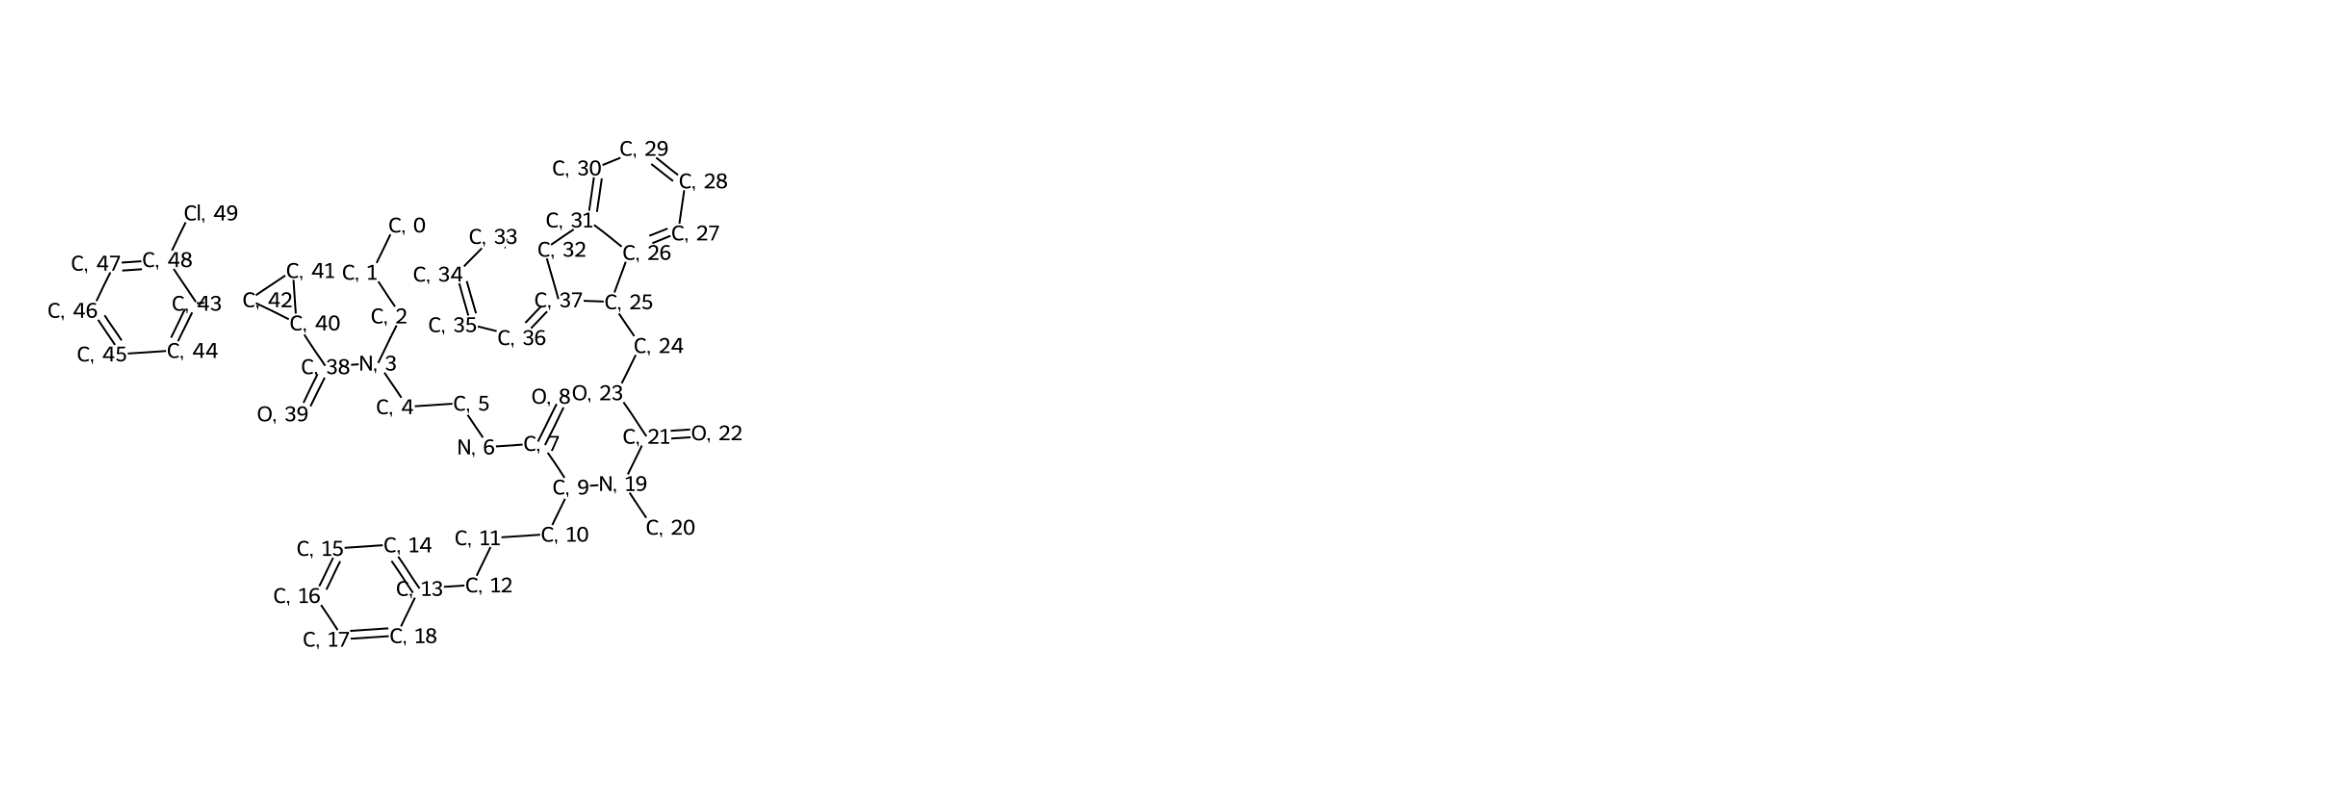

In [6]:
display_ligands(pharmit_dataset, indices=[idx])

## New Plinder Features

In [4]:
import zarr
root = zarr.open('/net/galaxy/home/koes/ltoft/OMTRA/data/plinder/exp/train.zarr', mode='r')
print(root.tree())

cfg = quick_load.load_cfg(overrides=['task_group=protein'], plinder_path='/net/galaxy/home/koes/ltoft/OMTRA/data/plinder')
datamodule = datamodule_from_config(cfg)
dataset = datamodule.load_dataset("train")
plinder_dataset = dataset.datasets['plinder']


/
├── apo
│   ├── atom_names (372923473,) object
│   ├── backbone_chain_ids (48123567,) object
│   ├── backbone_coords (48123567, 3, 3) float32
│   ├── backbone_mask (372923473,) bool
│   ├── backbone_res_ids (48123567,) int32
│   ├── backbone_res_names (48123567,) object
│   ├── chain_ids (372923473,) object
│   ├── coords (372923473, 3) float32
│   ├── elements (372923473,) object
│   ├── res_ids (372923473,) int32
│   └── res_names (372923473,) object
├── ligand
│   ├── atom_charges (3694127,) float32
│   ├── atom_types (3694127,) int32
│   ├── bond_indices (3927320, 2) int32
│   ├── bond_types (3927320,) int32
│   ├── coords (3694127, 3) float32
│   └── extra_feats (3694127, 6) int8
├── npnde
│   ├── atom_charges (4025,) float32
│   ├── atom_types (4025,) int32
│   ├── bond_indices (3996, 2) int32
│   ├── bond_types (3996,) int32
│   └── coords (4025, 3) float32
├── pharmacophore
│   ├── coords (2179024, 3) float32
│   ├── interactions (2179024,) bool
│   ├── types (2179024,) int32
│   └── vectors (2179024, 4, 3) float32
├── pocket
│   ├── atom_names (46262456,) object
│   ├── backbone_chain_ids (5881833,) object
│   ├── backbone_coords (5881833, 3, 3) float32
│   ├── backbone_mask (46262456,) bool
│   ├── backbone_res_ids (5881833,) int32
│   ├── backbone_res_names (5881833,) object
│   ├── chain_ids (46262456,) object
│   ├── coords (46262456, 3) float32
│   ├── elements (46262456,) object
│   ├── res_ids (46262456,) int32
│   └── res_names (46262456,) object
├── pred
│   ├── atom_names (0,) object
│   ├── backbone_chain_ids (0,) object
│   ├── backbone_coords (0, 3, 3) float32
│   ├── backbone_mask (0,) bool
│   ├── backbone_res_ids (0,) int32
│   ├── backbone_res_names (0,) object
│   ├── chain_ids (0,) object
│   ├── coords (0, 3) float32
│   ├── elements (0,) object
│   ├── res_ids (0,) int32
│   └── res_names (0,) object
└── receptor
    ├── atom_names (372923473,) object
    ├── backbone_chain_ids (48123567,) object
    ├── backbone_coords (48123567, 3, 3) float32
    ├── backbone_mask (372923473,) bool
    ├── backbone_res_ids (48123567,) int32
    ├── backbone_res_names (48123567,) object
    ├── chain_ids (372923473,) object
    ├── coords (372923473, 3) float32
    ├── elements (372923473,) object
    ├── res_ids (372923473,) int32
    └── res_names (372923473,) object


⚛ Instantiating datamodule <omtra.dataset.data_module.MultiTaskDataModule>


In [23]:
idx = 2891
data = plinder_dataset['exp']
g = data[('denovo_ligand', idx)]
print(g.nodes['lig'].data.keys())

start_idx, end_idx = data.retrieve_atom_idxs(idx)

print('impl_H, aro, hyb, ring, chiral, frag')
for i in range(start_idx, end_idx):
    print(i-start_idx, root['ligand/extra_feats'][i])

dict_keys(['x_1_true', 'a_1_true', 'c_1_true', 'impl_H_1_true', 'aro_1_true', 'hyb_1_true', 'ring_1_true', 'chiral_1_true', 'x_0', 'a_0', 'c_0'])
impl_H, aro, hyb, ring, chiral, frag
0 [0 1 3 1 0 0]
1 [0 1 3 1 0 0]
2 [1 1 3 1 0 0]
3 [0 1 3 1 0 0]
4 [1 1 3 1 0 0]
5 [1 1 3 1 0 0]
6 [1 0 3 0 0 0]
7 [1 0 3 0 0 0]
8 [0 0 4 0 0 0]


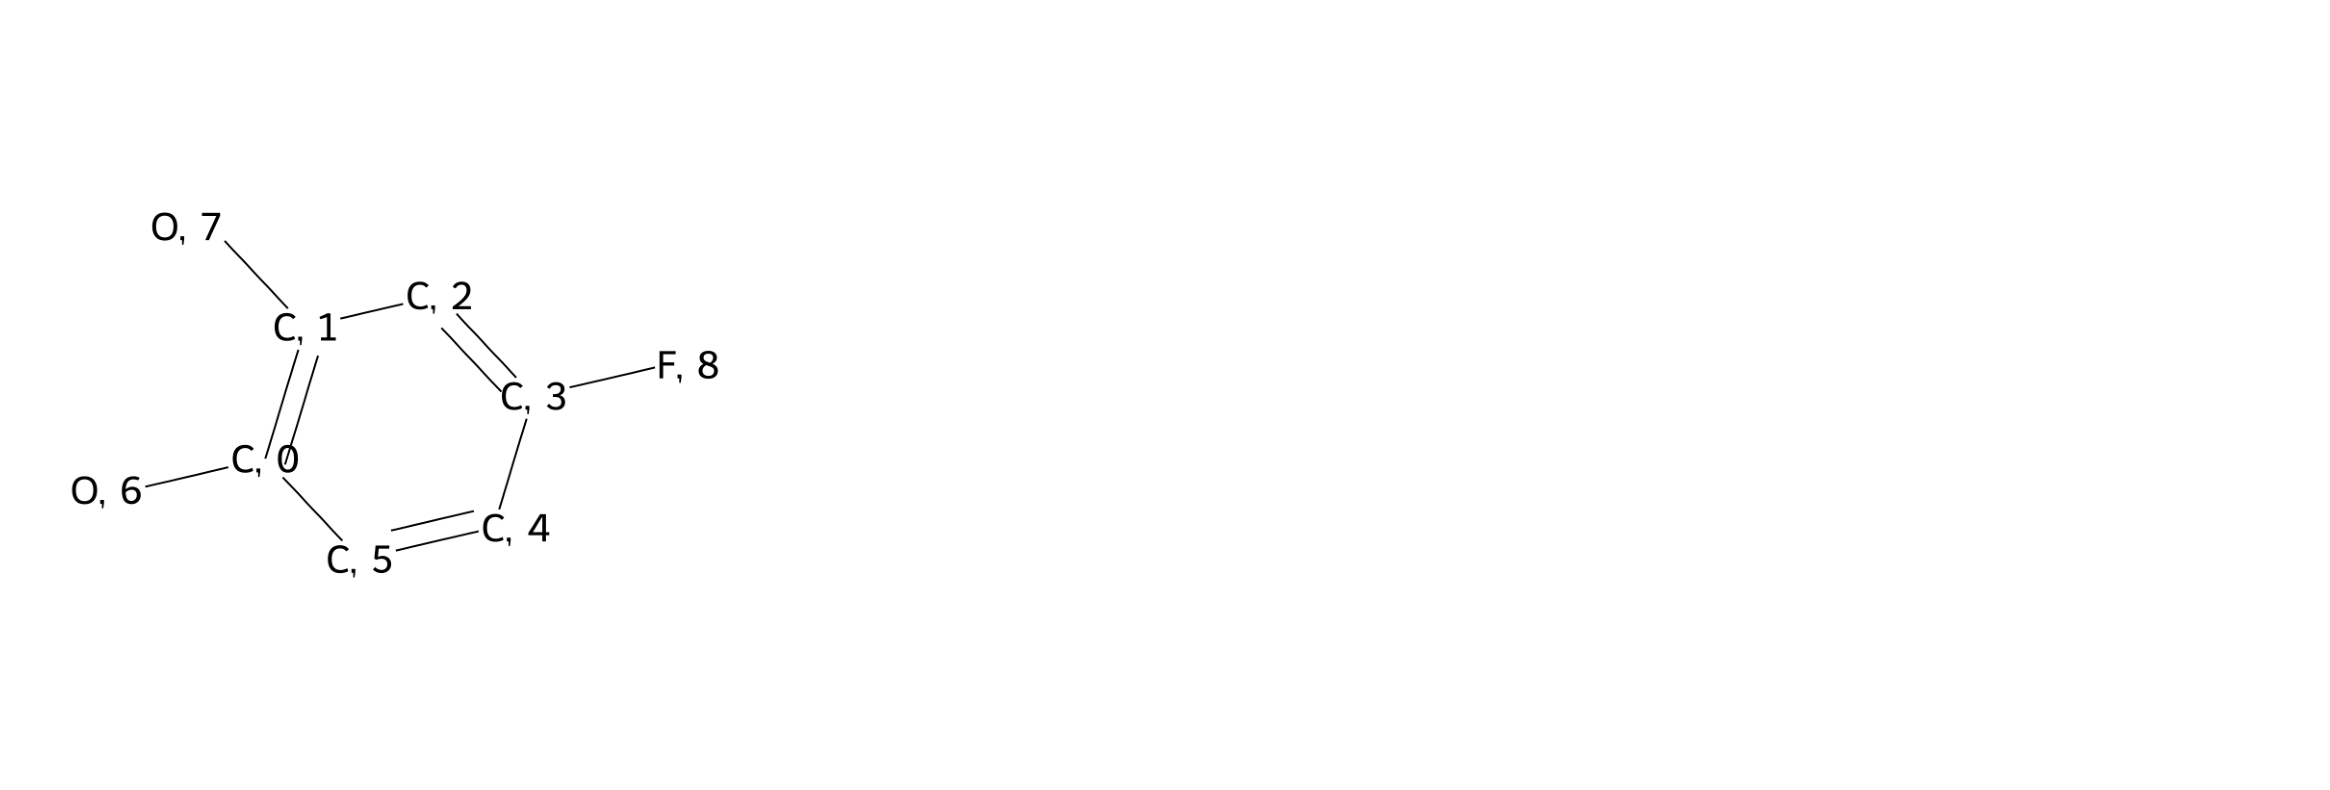

In [24]:
display_ligands(data, indices=[idx])